In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pylab as plt
import seaborn as sns
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from scipy import stats

In [18]:
data = pd.read_csv('data/GOOG.csv').set_index('Date')
data = data.drop(['Adj Close','Volume','High','Low','Open'], axis= 1)
data['Daily'] = 100 * (data['Close'].pct_change())
data['Returns[%]'] = (np.log(data['Close']) - np.log(data['Close'].shift(1))) * 100
data = data.dropna()
  # Function to calculate squared deviations from average return within a window
def squared_deviations(window_data):
    average_return = window_data.mean()
    return ((window_data - average_return)**2).mean()

windows = [10,15,20]
std_daily = data['Daily'].std()
for i in windows:
    data[f'Rv_{i}'] = data['Returns[%]'].iloc[::-1].rolling(window=i).apply(squared_deviations)
data.head()

,Close,Daily,Returns[%],Rv_10,Rv_15,Rv_20
Date,,,,,,
2014-02-05,28.473274,0.442816,0.441838,0.613933,0.456266,0.504845
2014-02-06,28.890711,1.466065,1.455422,0.628042,0.474654,0.506682
2014-02-07,29.326078,1.506947,1.495705,0.548184,0.425570,0.459933
2014-02-10,29.213751,-0.383030,-0.383765,0.427986,0.430738,0.384515
2014-02-11,29.643389,1.470670,1.459961,0.382514,0.454102,0.430674


In [19]:
data.describe()

,Close,Daily,Returns[%],Rv_10,Rv_15,Rv_20
count,2516.000000,2516.000000,2516.000000,2507.000000,2502.000000,2497.000000
mean,70.110941,0.079954,0.064470,2.835056,2.926262,2.972402
std,37.791500,1.760838,1.758127,3.765310,3.453358,3.224251
min,24.560070,-11.100818,-11.766725,0.044236,0.067998,0.080841
25%,38.115499,-0.710351,-0.712886,0.868681,0.998130,1.086128
50%,57.540749,0.084568,0.084532,1.647343,1.848489,1.986548
75%,102.174503,0.927611,0.923336,3.279695,3.557040,3.777856
max,154.839996,16.052425,14.887184,40.737450,34.426843,29.672392


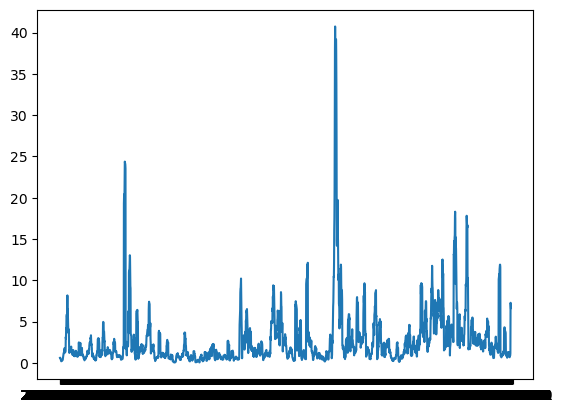

In [20]:
plt.plot(data['Rv_10'])

In [21]:
# Specify GARCH model assumptions
basic_gm = arch_model(data['Returns[%]'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)


Iteration:      4,   Func. Count:     30,   Neg. LLF: 4950.4613722467375
Iteration:      8,   Func. Count:     54,   Neg. LLF: 4797.276724676228
Iteration:     12,   Func. Count:     73,   Neg. LLF: 4797.2734150294955
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4797.273415028652
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


In [22]:
# Display model fitting summary
print(gm_result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Returns[%]   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4797.27
Distribution:                  Normal   AIC:                           9602.55
Method:            Maximum Likelihood   BIC:                           9625.87
                                        No. Observations:                 2516
Date:                Tue, Mar 26 2024   Df Residuals:                     2515
Time:                        21:16:20   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0713  3.324e-02      2.145  3.195e-02 [6.152e-0

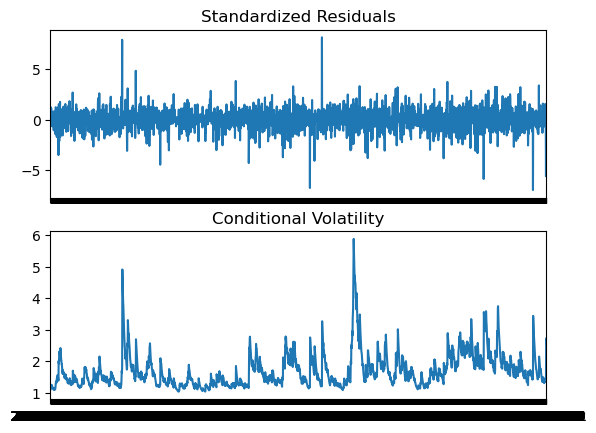

In [23]:
# Plot fitted results
gm_result.plot()
plt.show()


In [24]:
# Make n-period ahead forecast
for i in windows:
    gm_forecast = gm_result.forecast(horizon=i)

    print(gm_forecast.variance[-1:])

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2024-02-02  5.880995  5.790418  5.703204  5.619229  5.538372  5.460517   

                h.07      h.08      h.09      h.10  
Date                                                
2024-02-02  5.385553  5.313373  5.243873  5.176953  
                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2024-02-02  5.880995  5.790418  5.703204  5.619229  5.538372  5.460517   

                h.07      h.08      h.09      h.10      h.11      h.12  \
Date                                                                     
2024-02-02  5.385553  5.313373  5.243873  5.176953  5.112519  5.050477   

                h.13      h.14      h.15  
Date                                      
2024-02-02  4.990739  4.933219  4.877835  
                h.01      h.02      h.03   

/tmp/ipykernel_1790/1729988530.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')


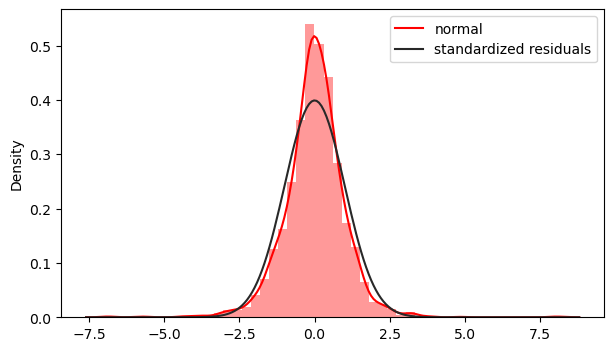

In [25]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()


In [26]:
# Specify GARCH model assumptions with Student's t-distribution
skewt_gm = arch_model(data['Returns[%]'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility


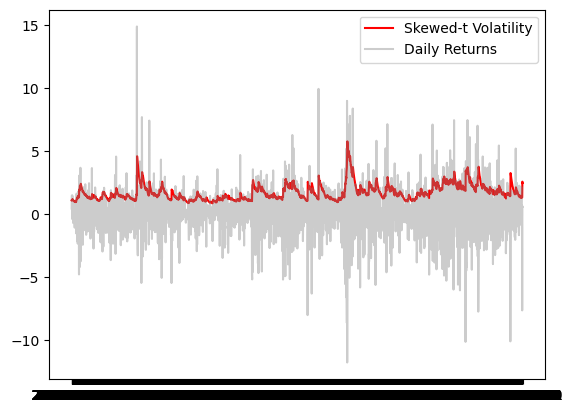

In [27]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(data['Returns[%]'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()
